Вообще, в датасете есть только текст и лейбл к данному посту. Предлагаю преобразовать текст через Word2Vec и попробовать разные модели множественной классификации для определения лучшей.
Label:
- sadness (0), 
- joy (1),
- love (2),
- anger (3),
- fear (4),
- surprise (5).

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("data/text.csv", index_col=0)

In [29]:
df.head()

,text,label
0,i just feel really helpless and heavy hearted,4
1,ive enjoyed being able to slouch about relax a...,0
2,i gave up my internship with the dmrg and am f...,4
3,i dont know i feel so lost,0
4,i am a kindergarten teacher and i am thoroughl...,4


In [30]:
df.shape

(416809, 2)

In [31]:
df.isna().sum()

text     0
label    0
dtype: int64

<Axes: xlabel='label', ylabel='Count'>

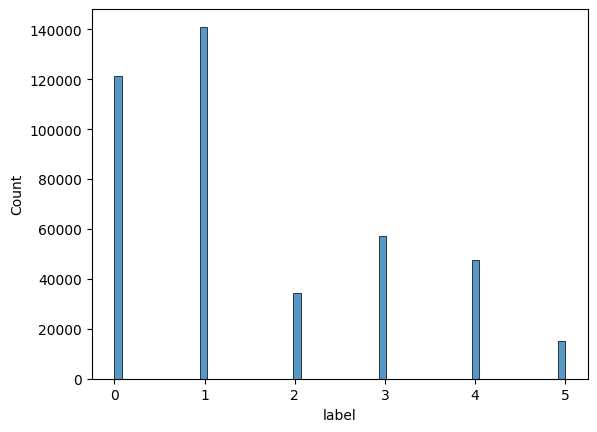

In [32]:
# Посмотрим на распределение классов
# Видно, что классы распределены не равномерно

import seaborn as sns

sns.histplot(data=df, x="label")

Преобразуем наш текст в фичи при помощи метода Word2Vec

In [6]:
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [7]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Error loading punkt: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading wordnet: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


In [8]:
def preprocess_text(text):
    tokens = word_tokenize(text)
    tokens = [word.lower() for word in tokens]
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return " ".join(tokens)

In [6]:
df["text"] = df["text"].apply(preprocess_text)

In [53]:
df.head()

,text,label
0,feel really helpless heavy hearted,4
1,ive enjoyed able slouch relax unwind frankly n...,0
2,gave internship dmrg feeling distraught,4
3,dont know feel lost,0
4,kindergarten teacher thoroughly weary job take...,4


In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()

In [9]:
X = tfidf_vectorizer.fit_transform(df["text"])

In [10]:
y = df["label"]

### Word2Vec

In [53]:
corpus = [preprocess_text(row["text"]) for index, row in df.iterrows()]

In [71]:
import numpy as np

In [57]:
w2v_model = Word2Vec(sentences=corpus, vector_size=100, window=5, min_count=1, sg=1)

In [79]:
vectorized_text = [np.mean(w2v_model.wv[t], axis=1) if t else np.zeros(100) for t in corpus]

In [84]:
max_len = max(len(v) for v in vectorized_text)
padded_vectors = [np.pad(v, (0, max_len - len(v)), 'constant') for v in vectorized_text]

In [93]:
padded_vectors = np.array(padded_vectors)

In [100]:
proceeded_df = pd.concat((df, pd.DataFrame(padded_vectors, columns=list(range(100)))), axis=1)

In [106]:
proceeded_df.to_csv("data/proceeded_data.csv", sep=",")

In [2]:
proceeded_df = pd.read_csv("data/proceeded_data.csv", index_col=0)

Таким образом мы получили представление текста вещественным вектором.<br>
Обучим модели классификации с замером их метрик:

### Разделений датасета

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, recall_score, PrecisionRecallDisplay, RocCurveDisplay, auc

В качестве baseline выберем модель, предсказывающую константное значение самого популярного лейбла (1)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
print(classification_report(y_test, [1 for i in range(X_test.shape[0])]))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     24201
           1       0.34      1.00      0.51     28164
           2       0.00      0.00      0.00      6929
           3       0.00      0.00      0.00     11441
           4       0.00      0.00      0.00      9594
           5       0.00      0.00      0.00      3033

    accuracy                           0.34     83362
   macro avg       0.06      0.17      0.08     83362
weighted avg       0.11      0.34      0.17     83362



d:\учёба\6 семестр\ПиКПО\emotion_analyser\venv\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\учёба\6 семестр\ПиКПО\emotion_analyser\venv\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\учёба\6 семестр\ПиКПО\emotion_analyser\venv\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

### Построим простую логистическую регрессию

In [11]:
lr_model = Pipeline([("scaler", StandardScaler()),
                     ("lr_regression", LogisticRegression())])

In [12]:
lr_model.fit(X=X_train, y=y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('lr_regression', LogisticRegression())])

In [13]:
from sklearn.metrics import classification_report

print(classification_report(y_test, lr_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.28      0.07      0.11     24201
           1       0.34      0.93      0.50     28164
           2       0.33      0.00      0.00      6929
           3       0.27      0.01      0.02     11441
           4       0.20      0.00      0.00      9594
           5       0.00      0.00      0.00      3033

    accuracy                           0.34     83362
   macro avg       0.24      0.17      0.10     83362
weighted avg       0.28      0.34      0.20     83362



d:\учёба\6 семестр\ПиКПО\emotion_analyser\venv\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\учёба\6 семестр\ПиКПО\emotion_analyser\venv\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\учёба\6 семестр\ПиКПО\emotion_analyser\venv\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

### RandomForest

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [15]:
rf_params = {
    "criterion": ["gini", "entropy"],
    "n_estimators": [100, 250, 500],
    "max_depth": [10, 15, 20]
}

In [ ]:
rf_model = RandomForestClassifier(random_state=2024)

In [19]:
search = GridSearchCV(rf_model, rf_params)
search.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
print(search.best_params_)
print(search.best_score_)

### XGBoost with default parameters

In [13]:
import xgboost as xgb

In [14]:
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

In [ ]:
params = {
    "eta": 0.2,
    "max_depth": 10
}
# params = {
#     "eta": 0.1,
#     "max_depth": 6
# }

In [15]:
bst_model = xgb.XGBClassifier(max_depth=6, eta=0.3)
bst_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.3, eval_metric=None,
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [16]:
print(classification_report(y_test, bst_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.95      0.92      0.93     24201
           1       0.93      0.89      0.91     28164
           2       0.74      0.91      0.82      6929
           3       0.93      0.86      0.90     11441
           4       0.86      0.85      0.85      9594
           5       0.68      0.91      0.78      3033

    accuracy                           0.90     83362
   macro avg       0.85      0.89      0.87     83362
weighted avg       0.90      0.90      0.90     83362



#### Сохранение модели

In [17]:
bst_model.save_model("model/xgboost.model")

d:\учёба\6 семестр\ПиКПО\emotion_analyser\venv\lib\site-packages\xgboost\core.py:160: UserWarning: [13:16:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


In [18]:
import pickle

with open("model/tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(tfidf_vectorizer, f)

In [1]:
import pickle
with open("model/tfidf_vectorizer.pkl", "rb") as f:
    loaded_tfidf = pickle.load(f)

In [2]:
import xgboost as xgb
loaded_model = xgb.XGBClassifier()
loaded_model.load_model("model/xgboost.model")

### Test

In [3]:
mapa = {
    0: "sadness", 
    1: "joy",
    2: "love",
    3: "anger",
    4: "fear",
    5: "surprise"
}

In [13]:
test_text = "Hi! Today I feel really beloved and I think it's because you!"

In [14]:
preproceeded_text = preprocess_text(test_text)

In [15]:
vector = loaded_tfidf.transform([preproceeded_text])

In [16]:
prediction = loaded_model.predict(vector)

print(mapa[prediction[0]])

love


In [17]:
loaded_model.predict_proba(vector)

array([[0.14271422, 0.32944128, 0.43183997, 0.05544803, 0.03960254,
        0.00095398]], dtype=float32)